# MNIST-SKLEARN-NN

The following script executes a program for digit recognition on the mnist database using SKLearn Multi-layer Perceptron classifier and PCA.

In [22]:
### Packages
import numpy as np
import pandas as pd
from datetime import datetime
import time

import sys

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.datasets import mnist

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import seaborn as sns


### Configurations
# Training-Size
num_train = 15000                   # 60000 for full data set 
num_test  = 2500                    # 10000 for full data set


# Use GridSearchCV to look up optimal parameters (see below)
hyper_parameter_search = False       # True/False: Run hyper-parameter search via GridSearchCV. Takes a long time.


In [23]:
# Simple function to log information
training_results = 'sklearn-nn-training-log.txt'
def log_training_results(*s):
    with open(training_results, 'a') as f:
        for arg in s:
            print(arg, file=f)
            print(arg)

# Simple function to log information
hyperparameter_search_log = 'sklearn-nn-hyperparameter-tuning-log.txt'
def log_hyperparameter_search(*s):
    with open(hyperparameter_search_log, 'a') as f:
        for arg in s:
            print(arg, file=f)
            print(arg)


In [24]:
# Fetch MNIST-Data from Keras repository
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [25]:
# Display (Train) (Test) datasets
print("Shape of training data:\t\t", X_train.shape)
print("Shape of training labels:\t", y_train.shape)
print("Shape of testing data:\t\t", X_test.shape)
print("Shape of testing labels:\t", y_test.shape)

# i.e.: We have 60000 images with a size of 28x28 pixels


Shape of training data:		 (60000, 28, 28)
Shape of training labels:	 (60000,)
Shape of testing data:		 (10000, 28, 28)
Shape of testing labels:	 (10000,)


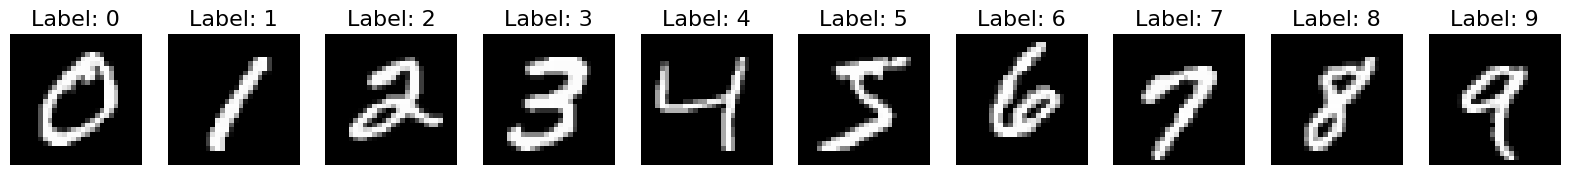

In [26]:
# Visualize some examples
num_classes = 10 # 0 .. 9
f, ax = plt.subplots(1, num_classes, figsize=(20,20))
for i in range(0, num_classes):
  sample = X_train[y_train == i][0]
  ax[i].imshow(sample, cmap='gray')
  ax[i].set_title("Label: {}".format(i), fontsize=16)
  ax[i].axis('off')

In [27]:
# Reshape the data such that we have access to every pixel of the image
# The reason to access every pixel is that only then we can apply deep learning ideas and can assign color code to every pixel.
train_data = X_train.reshape((X_train.shape[0], 28*28)).astype('float32')
train_label = y_train.astype("float32")

test_data = X_test.reshape((X_test.shape[0], 28*28)).astype('float32')
test_label = y_test.astype("float32")

In [28]:
# We know the RGB color code where different values produce various colors. It is also difficult to remember every color combination. 
# We already know that each pixel has its unique color code and also we know that it has a maximum value of 255. 
# To perform Machine Learning, it is important to convert all the values from 0 to 255 for every pixel to a range of values from 0 to 1.
train_data = train_data / 255
test_data = test_data / 255

In [29]:
# Force the amount of columns to fit the necessary sizes required by the neural network
#train_label = keras.utils.to_categorical(train_label, num_classes)
#test_label = keras.utils.to_categorical(test_label, num_classes)

In [30]:
# As an optional step, we decrease the training and testing data size, such that the algorithms perform their execution in acceptable time
train_data = train_data[1:num_train,]
train_label = train_label[1:num_train]

test_data = test_data[1:num_test,]
test_label = test_label[1:num_test]

In [31]:
# Display (Train) (Test) datasets

print("Reshaped training data:\t\t", train_data.shape)
print("Reshaped training labels:\t", train_label.shape)
print("Reshaped testing data:\t\t", test_data.shape)
print("Reshaped testing labels:\t", test_label.shape)

# As we can see: We now have X images with 784 pixels in total
# We now operate on this data

Reshaped training data:		 (14999, 784)
Reshaped training labels:	 (14999,)
Reshaped testing data:		 (2499, 784)
Reshaped testing labels:	 (2499,)


## Multi-layer Perceptron classifier

This model optimizes the log-loss function using LBFGS or stochastic gradient descent.

For more information, see: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

In [32]:
# The default layout of mlp() 
# @see https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
mlp = MLPClassifier(
    hidden_layer_sizes=(100,),      # The ith element represents the number of neurons in the ith hidden layer.
    activation='relu',              # Activation function for the hidden layer.
    solver='adam',                  # The solver for weight optimization.
    alpha=0.0001,                   # Strength of the L2 regularization term. The L2 regularization term is divided by the sample size when added to the loss.
    batch_size='auto',              # Size of minibatches for stochastic optimizers. If the solver is ‘lbfgs’, the classifier will not use minibatch. When set to “auto”, batch_size=min(200, n_samples).
    learning_rate='constant',       # Learning rate schedule for weight updates.
    learning_rate_init=0.001,       # The initial learning rate used. It controls the step-size in updating the weights. Only used when solver=’sgd’ or ‘adam’.
    power_t=0.5,                    # The exponent for inverse scaling learning rate. It is used in updating effective learning rate when the learning_rate is set to ‘invscaling’. Only used when solver=’sgd’.
    max_iter=200,                   # Maximum number of iterations. The solver iterates until convergence (determined by ‘tol’) or this number of iterations.
    shuffle=True,                   # Whether to shuffle samples in each iteration. Only used when solver=’sgd’ or ‘adam’.
    random_state=None,              # Determines random number generation for weights and bias initialization, train-test split if early stopping is used, and batch sampling when solver=’sgd’ or ‘adam’.
    tol=0.0001,                     # Tolerance for the optimization. When the loss or score is not improving by at least tol for n_iter_no_change consecutive iterations, unless learning_rate is set to ‘adaptive’, convergence is considered to be reached and training stops.
    verbose=False,                  # Whether to print progress messages to stdout.
    warm_start=False,               # When set to True, reuse the solution of the previous call to fit as initialization, otherwise, just erase the previous solution.
    momentum=0.9,                   # Momentum for gradient descent update. Should be between 0 and 1. Only used when solver=’sgd’.
    nesterovs_momentum=True,        # Whether to use Nesterov’s momentum. Only used when solver=’sgd’ and momentum > 0.
    early_stopping=False,           # Whether to use early stopping to terminate training when validation score is not improving. 
    validation_fraction=0.1,        # The proportion of training data to set aside as validation set for early stopping. Only used if early_stopping is True.
    beta_1=0.9,                     # Exponential decay rate for estimates of first moment vector in adam, should be in [0, 1). Only used when solver=’adam’.
    beta_2=0.999,                   # Exponential decay rate for estimates of second moment vector in adam, should be in [0, 1). Only used when solver=’adam’.
    epsilon=1e-08,                  # Value for numerical stability in adam. Only used when solver=’adam’.
    n_iter_no_change=10,            # Maximum number of epochs to not meet tol improvement. Only effective when solver=’sgd’ or ‘adam’.
    max_fun=15000                   # Only used when solver=’lbfgs’. Maximum number of loss function calls. 
)

In [33]:
# Fit the model to data matrix X and target(s) y.
#   X ... ndarray or sparse matrix of shape (n_samples, n_features), the input data
#   y ... ndarray of shape (n_samples,) or (n_samples, n_outputs), the target values (class labels in classification, real numbers in regression)

start_time = time.time()
mlp.fit(train_data, train_label)
end_time = time.time() - start_time

params = {"MLP":{'activation':mlp.get_params()["activation"], 'alpha':mlp.get_params()["alpha"], 'epsilon':mlp.get_params()["epsilon"], 'hidden_layer_sizes':mlp.get_params()["hidden_layer_sizes"]}}
log_training_results("[%s] Trained new model: %s in %s seconds" % (datetime.now(), params, end_time))



[2022-09-09 12:08:11.707880] Trained new model: {'MLP': {'activation': 'relu', 'alpha': 0.0001, 'epsilon': 1e-08, 'hidden_layer_sizes': (100,)}} in 14.891449928283691 seconds


In [34]:
# Predict using the multi-layer perceptron classifier.
#   X ... {array-like, sparse matrix} of shape (n_samples, n_features)
start_time = time.time()
predictions = mlp.predict(test_data)
end_time = time.time() - start_time

log_training_results("\tRunning Predictions on Test-Data --  execution time: %ss" % (end_time))


	Running Predictions on Test-Data --  execution time: 0.011055707931518555s


In [35]:

start_time = time.time()
score = mlp.score(train_data, train_label)
end_time = time.time() - start_time
log_training_results("\tScore data on %s -- mean accuracy on train-data: %s; execution time: %ss" % (params, score, end_time))  

start_time = time.time()
score = mlp.score(test_data, test_label)
end_time = time.time() - start_time
log_training_results("\tScore data on %s -- mean accuracy on test-data: %s; execution time: %ss" % (params, score, end_time))  

	Score data on {'MLP': {'activation': 'relu', 'alpha': 0.0001, 'epsilon': 1e-08, 'hidden_layer_sizes': (100,)}} -- mean accuracy on train-data: 1.0; execution time: 0.05613255500793457s
	Score data on {'MLP': {'activation': 'relu', 'alpha': 0.0001, 'epsilon': 1e-08, 'hidden_layer_sizes': (100,)}} -- mean accuracy on test-data: 0.9491796718687475; execution time: 0.008677959442138672s


In [36]:
# # Hyperparameter search -- Takes up a long time.
if hyper_parameter_search:
    mlp = MLPClassifier(max_iter=100)
    parameters = {
        'hidden_layer_sizes': [(28,28),(784,)],
        'activation': ['tanh', 'relu'],
        'solver': ['sgd', 'adam'],
        'alpha': [0.0001, 0.05],
        'learning_rate': ['constant','adaptive'],
    }

    log_hyperparameter_search("--- [%s] Running Parameter-Tests [SKLEARN-NN] ---" % datetime.now())

    grid = GridSearchCV(estimator=mlp, param_grid=parameters, verbose=3, n_jobs=-1)
    grid.fit(train_data, train_label)

    log_hyperparameter_search("Best parameters set found on following development set:")
    log_hyperparameter_search("\tSupport Vector: %s" % grid.best_estimator_)
    log_hyperparameter_search("\tSupport Vector Parametrization: %s" % grid.best_params_)
    log_hyperparameter_search("\tAsserted Score: %s" % grid.best_score_)
    log_hyperparameter_search("Total Score \t\t Configurations")
    means = grid.cv_results_["mean_test_score"]
    stds = grid.cv_results_["std_test_score"]
    params = grid.cv_results_["params"]
    for mean, std, params in zip(means, stds, params):
        log_hyperparameter_search("%0.3f (+/-%0.03f)\t%r" % (mean, std, params))
    print("Wrote classifier comparisons to file ", hyperparameter_search_log)

    print("Detailed classification report:")
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")

    y_true, y_pred = test_label, grid.predict(test_data)
    print(classification_report(y_true, y_pred))
    print()


## Multi-layer Perceptron classifier - Principal Component Analysis

This model optimizes the log-loss function using LBFGS or stochastic gradient descent, on data that is transformed using PCA.

For more information, see: 
- https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
- https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html 

In [37]:
# Fitting the PCA algorithm with the datasets
pca = PCA(
    n_components=None, 
    copy=True, 
    whiten=False, 
    svd_solver='auto', 
    tol=0.0, 
    iterated_power='auto', 
    n_oversamples=10, 
    power_iteration_normalizer='auto', 
    random_state=None
)
pca.fit(train_data, train_label)

PCA()

In [38]:
# Reshaping the data based on the PCA
pca_train_data = pca.transform(train_data)
pca_test_data = pca.transform(test_data)

In [39]:
# Fit the model to data matrix X and target(s) y.
start_time = time.time()
mlp.fit(pca_train_data, train_label)
end_time = time.time() - start_time

params = {"MLP-PCA":{'activation':mlp.get_params()["activation"], 'alpha':mlp.get_params()["alpha"], 'epsilon':mlp.get_params()["epsilon"], 'hidden_layer_sizes':mlp.get_params()["hidden_layer_sizes"]}}
log_training_results("[%s] Trained new model: %s in %s seconds" % (datetime.now(), params, end_time))


[2022-09-09 12:08:25.565040] Trained new model: {'MLP-PCA': {'activation': 'relu', 'alpha': 0.0001, 'epsilon': 1e-08, 'hidden_layer_sizes': (100,)}} in 11.628486633300781 seconds


In [40]:
# Predict using the multi-layer perceptron classifier.

start_time = time.time()
predictions = mlp.predict(pca_test_data)
end_time = time.time() - start_time

log_training_results("\tRunning Predictions on Test-Data --  execution time: %ss" % (end_time))

	Running Predictions on Test-Data --  execution time: 0.011519432067871094s


In [41]:

start_time = time.time()
score = mlp.score(train_data, train_label)
end_time = time.time() - start_time
log_training_results("\tScore data on %s -- mean accuracy on train-data: %s; execution time: %ss" % (params, score, end_time))  

start_time = time.time()
score = mlp.score(test_data, test_label)
end_time = time.time() - start_time
log_training_results("\tScore data on %s -- mean accuracy on test-data: %s; execution time: %ss" % (params, score, end_time))  

	Score data on {'MLP-PCA': {'activation': 'relu', 'alpha': 0.0001, 'epsilon': 1e-08, 'hidden_layer_sizes': (100,)}} -- mean accuracy on train-data: 0.12767517834522302; execution time: 0.06981945037841797s
	Score data on {'MLP-PCA': {'activation': 'relu', 'alpha': 0.0001, 'epsilon': 1e-08, 'hidden_layer_sizes': (100,)}} -- mean accuracy on test-data: 0.13765506202480993; execution time: 0.01327824592590332s


In [42]:
# # Hyperparameter search -- Takes up a long time.
if hyper_parameter_search:
    mlp_gs = MLPClassifier(max_iter=100)
    parameters = {
        'hidden_layer_sizes': [(28,28),(784,)],
        'activation': ['tanh', 'relu'],
        'solver': ['sgd', 'adam'],
        'alpha': [0.0001, 0.05],
        'learning_rate': ['constant','adaptive'],
    }

    log_hyperparameter_search("--- [%s] Running Parameter-Tests [SKLEARN-NN] ---" % datetime.now())


    grid = GridSearchCV(estimator=mlp_gs, param_grid=parameters, verbose=3, n_jobs=-1)
    grid.fit(pca_train_data, train_label)

    log_hyperparameter_search("Best parameters set found on following development set:")
    log_hyperparameter_search("\tSupport Vector: %s" % grid.best_estimator_)
    log_hyperparameter_search("\tSupport Vector Parametrization: %s" % grid.best_params_)
    log_hyperparameter_search("\tAsserted Score: %s" % grid.best_score_)
    log_hyperparameter_search("Total Score \t\t Configurations")
    means = grid.cv_results_["mean_test_score"]
    stds = grid.cv_results_["std_test_score"]
    params = grid.cv_results_["params"]
    for mean, std, params in zip(means, stds, params):
        log_hyperparameter_search("%0.3f (+/-%0.03f)\t%r" % (mean, std, params))
    print("Wrote classifier comparisons to file ", hyperparameter_search_log)

    print("Detailed classification report:")
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")

    y_true, y_pred = test_label, grid.predict(test_data)
    print(classification_report(y_true, y_pred))
    print()
